# Detrend model data
- This is a data pre-processing notebook
- We will read CESM2 LENS daily temperature data (max,min and mean) and detrend it

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
import intake
import zarr
import nc_time_axis
#import xskillscore as xs
import cartopy as cart
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from datetime import datetime, timedelta
import pandas as pd

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [3]:
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
catalog_url = 'https://data.rda.ucar.edu/harshah/intake_catalogs/posix/cesm2-lens/rda-cesm2-lens-posix.json'
rda_data    = '/gpfs/csfs1/collections/rda/data/harshah/'
###
tmean_path  = rda_data + 'mdm_data/tmean/'
tmax_path   = rda_data + 'mdm_data/tmax/'
tmin_path   = rda_data + 'mdm_data/tmin/'
############
pi_year  = 1865
eoc_year = 2085
#
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'
doy       = 211 # day_of_year

In [4]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')
###############################
date = no_leap_date(doy)

In [5]:
def to_daily(ds):
    year       = ds.time.dt.year
    dayofyear  = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time", dayofyear.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time") 

In [6]:
def detrend_all(ds, central_year):
    # Assumes that the ds has coordinates day, year and member.
    
    #Fit a linear fuction and extract slope
    pcoeffs = ds.mean('member_id').polyfit(dim='year',deg=1)
    #print(pcoeffs)
    slope   = pcoeffs.polyfit_coefficients.sel(degree=1)
    
    #Calculate trend
    ds_trend   = slope*(ds['year']- central_year)
    
    #Detrend by subtracting the trend from the data
    ds_detrended = ds  - ds_trend
    
    return ds_detrended

In [7]:
def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

#
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

In [8]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34835 instead
  warnings.warn(


In [9]:
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/34835/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.97:46241,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/34835/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
cluster.scale(12)

In [11]:
# cluster

## Load CESM2 LENS zarr data

In [12]:
# Open collection description file using intake
col         = intake.open_esm_datastore(catalog_url)
col

,unique
Unnamed: 0,322
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20


In [13]:
mean_temps = col.search(variable ='TREFHT', frequency ='daily')
mean_temps

,unique
Unnamed: 0,4
variable,1
long_name,1
component,1
experiment,2
forcing_variant,2
frequency,1
vertical_levels,1
spatial_domain,1
units,1


### Detrend daily mean temperatures

In [14]:
ds_tmean = mean_temps.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


In [15]:
ds_tmean.keys()

dict_keys(['atm.ssp370.daily.smbb', 'atm.historical.daily.smbb', 'atm.ssp370.daily.cmip6', 'atm.historical.daily.cmip6'])

In [16]:
dsmean_pi_cmip6 = ds_tmean['atm.historical.daily.cmip6'].TREFHT.sel(time=slice(pi_year0,pi_year1))
dsmean_pi_smbb  = ds_tmean['atm.historical.daily.smbb'].TREFHT.sel(time=slice(pi_year0,pi_year1))
# dsmean_pi_smbb
dsmean_eoc_cmip6 = ds_tmean['atm.ssp370.daily.cmip6'].TREFHT.sel(time=slice(ic_year0,ic_year1))
dsmean_eoc_smbb  = ds_tmean['atm.ssp370.daily.smbb'].TREFHT.sel(time=slice(ic_year0,ic_year1))

In [17]:
%%time
# Merge datasets to obtain pre-industrial and EOC daily mean temperatures
pi_tmeans  = xr.concat([dsmean_pi_cmip6,dsmean_pi_smbb],dim='member_id')
eoc_tmeans = xr.concat([dsmean_eoc_cmip6,dsmean_eoc_smbb],dim='member_id')

CPU times: user 18.8 ms, sys: 0 ns, total: 18.8 ms
Wall time: 19.3 ms


In [18]:
pi_tmean_daily  = to_daily(pi_tmeans)
eoc_tmean_daily = to_daily(eoc_tmeans)
pi_tmean_daily  = pi_tmean_daily.chunk({'lat':48,'year':30,'dayofyear':30})
eoc_tmean_daily = eoc_tmean_daily.chunk({'lat':48,'year':30,'dayofyear':30})

In [19]:
%%time
# pi_tmean_daily.to_dataset().to_zarr(tmean_path +'pre_ind_daily_tmean.zarr',mode='w')
# eoc_tmean_daily.to_dataset().to_zarr(tmean_path +'eoc_daily_tmean.zarr',mode='w')

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.05 μs


In [20]:
%%time
pi_tmean_daily  = xr.open_zarr(tmean_path +'pre_ind_daily_tmean.zarr').TREFHT
eoc_tmean_daily = xr.open_zarr(tmean_path +'eoc_daily_tmean.zarr').TREFHT

CPU times: user 22.4 ms, sys: 0 ns, total: 22.4 ms
Wall time: 22.6 ms


In [21]:
pi_tmean_detrended  = detrend_all(pi_tmean_daily,pi_year)
eoc_tmean_detrended = detrend_all(eoc_tmean_daily,eoc_year)
#
pi_tmean_detrended  = pi_tmean_detrended.rename('detrended_tmean')
eoc_tmean_detrended = eoc_tmean_detrended.rename('detrended_tmean')

In [22]:
# %%time
# pi_tmean_detrended.to_dataset().to_zarr(tmean_path +'pre_ind_detrended_tmean.zarr',mode='w')
# eoc_tmean_detrended.to_dataset().to_zarr(tmean_path +'eoc_detrended_tmean.zarr',mode='w')

#### Check if detrending worked

In [23]:
pi_tmean_detrended  = xr.open_zarr(tmean_path +'pre_ind_detrended_tmean.zarr').detrended_tmean
eoc_tmean_detrended = xr.open_zarr(tmean_path +'eoc_detrended_tmean.zarr').detrended_tmean

CPU times: user 4.59 s, sys: 5.74 s, total: 10.3 s
Wall time: 29.8 s


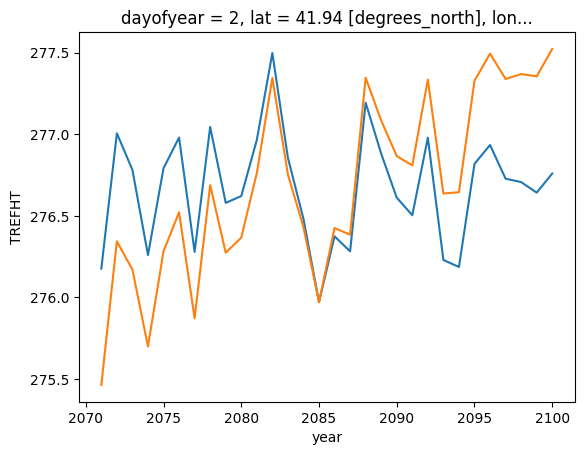

In [24]:
%%time
eoc_tmean_detrended.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()
eoc_tmean_daily.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()

CPU times: user 4.29 s, sys: 5.92 s, total: 10.2 s
Wall time: 26.9 s


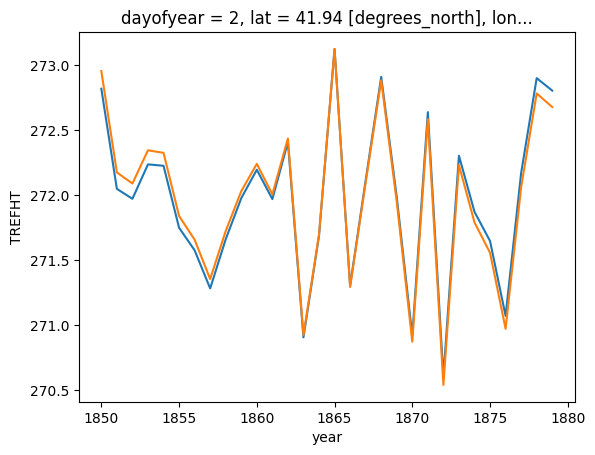

In [25]:
%%time
pi_tmean_detrended.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()
pi_tmean_daily.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()

### Detrend daily max temperatures

In [26]:
max_temps = col.search(variable ='TREFHTMX', frequency ='daily')
# max_temps

In [27]:
ds_tmax = max_temps.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


In [28]:
ds_tmax.keys()

dict_keys(['atm.ssp370.daily.smbb', 'atm.historical.daily.smbb', 'atm.ssp370.daily.cmip6', 'atm.historical.daily.cmip6'])

In [29]:
dsmax_pi_cmip6 = ds_tmax['atm.historical.daily.cmip6'].TREFHTMX.sel(time=slice(pi_year0,pi_year1))
dsmax_pi_smbb  = ds_tmax['atm.historical.daily.smbb'].TREFHTMX.sel(time=slice(pi_year0,pi_year1))
# dsmax_pi_smbb
dsmax_eoc_cmip6 = ds_tmax['atm.ssp370.daily.cmip6'].TREFHTMX.sel(time=slice(ic_year0,ic_year1))
dsmax_eoc_smbb  = ds_tmax['atm.ssp370.daily.smbb'].TREFHTMX.sel(time=slice(ic_year0,ic_year1))

In [30]:
%%time
# Merge datasets to obtain pre-industrial and EOC daily mean temperatures
pi_tmax  = xr.concat([dsmax_pi_cmip6,dsmax_pi_smbb],dim='member_id')
eoc_tmax = xr.concat([dsmax_eoc_cmip6,dsmax_eoc_smbb],dim='member_id')

CPU times: user 19 ms, sys: 0 ns, total: 19 ms
Wall time: 19.1 ms


In [31]:
pi_tmax_daily  = to_daily(pi_tmax)
eoc_tmax_daily = to_daily(eoc_tmax)
pi_tmax_daily  = pi_tmax_daily.chunk({'lat':48,'year':30,'dayofyear':30})
eoc_tmax_daily = eoc_tmax_daily.chunk({'lat':48,'year':30,'dayofyear':30})

In [32]:
# %%time
# pi_tmax_daily.to_dataset().to_zarr(tmax_path +'pre_ind_daily_tmax.zarr',mode='w')
# eoc_tmax_daily.to_dataset().to_zarr(tmax_path +'eoc_daily_tmax.zarr',mode='w')

In [33]:
%%time
pi_tmax_daily  = xr.open_zarr(tmax_path +'pre_ind_daily_tmax.zarr').TREFHTMX
eoc_tmax_daily = xr.open_zarr(tmax_path +'eoc_daily_tmax.zarr').TREFHTMX

CPU times: user 23.9 ms, sys: 0 ns, total: 23.9 ms
Wall time: 44.8 ms


In [34]:
pi_tmax_detrended  = detrend_all(pi_tmax_daily,pi_year)
eoc_tmax_detrended = detrend_all(eoc_tmax_daily,eoc_year)
#
pi_tmax_detrended  = pi_tmax_detrended.rename('detrended_tmax')
eoc_tmax_detrended = eoc_tmax_detrended.rename('detrended_tmax')

In [35]:
# %%time
# pi_tmax_detrended.to_dataset().to_zarr(tmax_path +'pre_ind_detrended_tmax.zarr',mode='w')

In [36]:
# %%time
# eoc_tmax_detrended.to_dataset().to_zarr(tmax_path +'eoc_detrended_tmax.zarr',mode='w')

#### Check if detrending worked

In [37]:
pi_tmax_detrended  = xr.open_zarr(tmax_path +'pre_ind_detrended_tmax.zarr').detrended_tmax
eoc_tmax_detrended = xr.open_zarr(tmax_path +'eoc_detrended_tmax.zarr').detrended_tmax

CPU times: user 4.12 s, sys: 6.14 s, total: 10.3 s
Wall time: 25.9 s


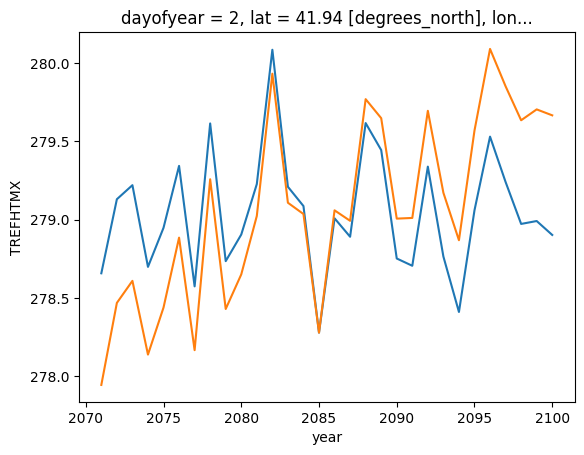

In [38]:
%%time
eoc_tmax_detrended.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()
eoc_tmax_daily.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()

CPU times: user 4.33 s, sys: 5.81 s, total: 10.1 s
Wall time: 24.9 s


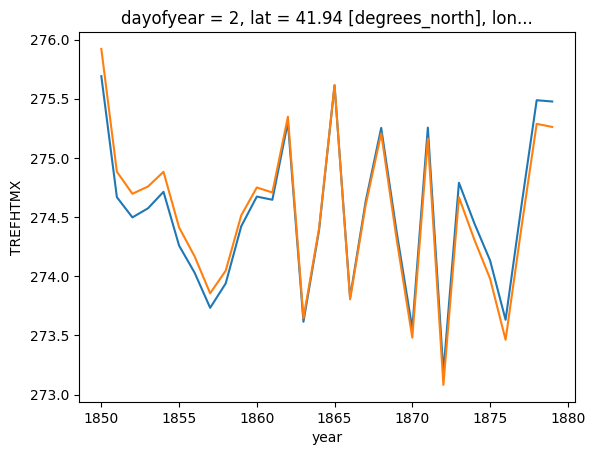

In [39]:
%%time
pi_tmax_detrended.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()
pi_tmax_daily.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()

### Detrend daily min temperatures

In [40]:
min_temps = col.search(variable ='TREFHTMN', frequency ='daily')
min_temps

,unique
Unnamed: 0,4
variable,1
long_name,1
component,1
experiment,2
forcing_variant,2
frequency,1
vertical_levels,1
spatial_domain,1
units,1


In [41]:
ds_tmin = min_temps.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


In [42]:
ds_tmin.keys()

dict_keys(['atm.ssp370.daily.smbb', 'atm.historical.daily.smbb', 'atm.ssp370.daily.cmip6', 'atm.historical.daily.cmip6'])

In [43]:
dsmin_pi_cmip6 = ds_tmin['atm.historical.daily.cmip6'].TREFHTMN.sel(time=slice(pi_year0,pi_year1))
dsmin_pi_smbb  = ds_tmin['atm.historical.daily.smbb'].TREFHTMN.sel(time=slice(pi_year0,pi_year1))
# dsmax_pi_smbb
dsmin_eoc_cmip6 = ds_tmin['atm.ssp370.daily.cmip6'].TREFHTMN.sel(time=slice(ic_year0,ic_year1))
dsmin_eoc_smbb  = ds_tmin['atm.ssp370.daily.smbb'].TREFHTMN.sel(time=slice(ic_year0,ic_year1))

In [44]:
%%time
# Merge datasets to obtain pre-industrial and EOC daily mean temperatures
pi_tmin  = xr.concat([dsmin_pi_cmip6,dsmin_pi_smbb],dim='member_id')
eoc_tmin = xr.concat([dsmin_eoc_cmip6,dsmin_eoc_smbb],dim='member_id')

CPU times: user 19.5 ms, sys: 0 ns, total: 19.5 ms
Wall time: 19.9 ms


In [45]:
pi_tmin_daily  = to_daily(pi_tmin)
eoc_tmin_daily = to_daily(eoc_tmin)
pi_tmin_daily  = pi_tmin_daily.chunk({'lat':48,'year':30,'dayofyear':30})
eoc_tmin_daily = eoc_tmin_daily.chunk({'lat':48,'year':30,'dayofyear':30})

In [46]:
# %%time
# pi_tmin_daily.to_dataset().to_zarr(tmin_path +'pre_ind_daily_tmin.zarr',mode='w')
# eoc_tmin_daily.to_dataset().to_zarr(tmin_path +'eoc_daily_tmin.zarr',mode='w')

In [47]:
%%time
pi_tmin_daily  = xr.open_zarr(tmin_path +'pre_ind_daily_tmin.zarr').TREFHTMN
eoc_tmin_daily = xr.open_zarr(tmin_path +'eoc_daily_tmin.zarr').TREFHTMN

CPU times: user 24.3 ms, sys: 37 μs, total: 24.3 ms
Wall time: 24.5 ms


In [48]:
pi_tmin_detrended  = detrend_all(pi_tmin_daily,pi_year)
eoc_tmin_detrended = detrend_all(eoc_tmin_daily,eoc_year)
#
pi_tmin_detrended  = pi_tmin_detrended.rename('detrended_tmin')
eoc_tmin_detrended = eoc_tmin_detrended.rename('detrended_tmin')
eoc_tmin_detrended

<xarray.DataArray 'detrended_tmin' (member_id: 100, lat: 192, lon: 288,
                                    year: 30, dayofyear: 365)> Size: 484GB
dask.array<sub, shape=(100, 192, 288, 30, 365), dtype=float64, chunksize=(1, 48, 288, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * year       (year) int64 240B 2071 2072 2073 2074 ... 2097 2098 2099 2100
    degree     int64 8B 1

In [49]:
# %%time
# pi_tmin_detrended.to_dataset().to_zarr(tmin_path +'pre_ind_detrended_tmin.zarr',mode='w')

In [50]:
# %%time
# eoc_tmin_detrended.to_dataset().to_zarr(tmin_path +'eoc_detrended_tmin.zarr',mode='w')

CPU times: user 31min 59s, sys: 14min 25s, total: 46min 24s
Wall time: 1h 13min 55s


#### Check if detrending worked

In [51]:
pi_tmin_detrended  = xr.open_zarr(tmin_path +'pre_ind_detrended_tmin.zarr').detrended_tmin
eoc_tmin_detrended = xr.open_zarr(tmin_path +'eoc_detrended_tmin.zarr').detrended_tmin

CPU times: user 4.39 s, sys: 6.16 s, total: 10.6 s
Wall time: 31.3 s


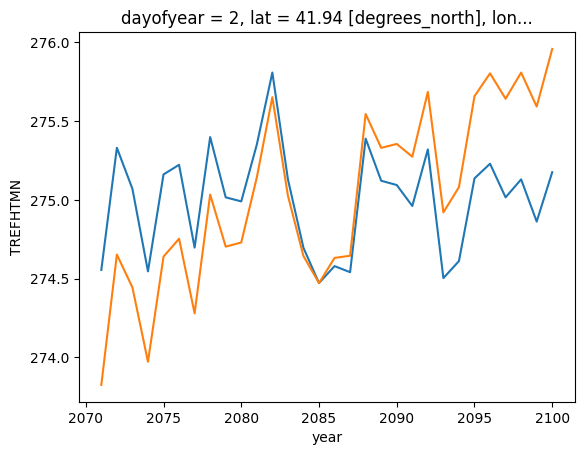

In [52]:
%%time
eoc_tmin_detrended.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()
eoc_tmin_daily.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()

CPU times: user 4.24 s, sys: 6.14 s, total: 10.4 s
Wall time: 27.6 s


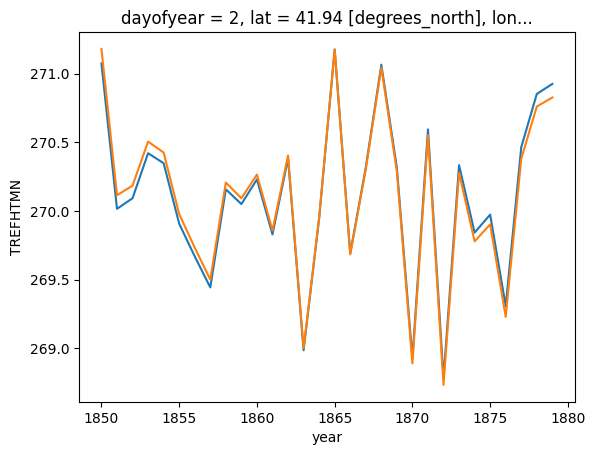

In [53]:
%%time
pi_tmin_detrended.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()
pi_tmin_daily.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('member_id').plot()

In [55]:
cluster.close()